# LIDC

# CNN - DenseNet 3D

In [1]:
import os
import pandas as pd
import numpy as np
import time
import random
import cv2
import pydicom
import SimpleITK as sitk

import torch
import torchvision
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from collections import defaultdict


from sklearn.model_selection import train_test_split
from tqdm import tqdm
import csv
import matplotlib.pyplot as plt

from glob import glob
from PIL import Image

from monai.transforms import (
    Compose, Resize, LoadImaged, RepeatChanneld, ScaleIntensity, ResizeWithPadOrCropd, ToTensord,
    RandGaussianNoise, RandAdjustContrast, RandGaussianSmooth, Rand3DElasticd, RandBiasField, 
    RandCropByPosNegLabeld, Resized, RandFlip, RandAffine, Compose, Resize
)

from monai.data import DataLoader, Dataset
from collections import Counter
from torchvision import models
from torchinfo import summary
from torchvision import datasets, transforms
from torch.utils.data import random_split, DataLoader, Dataset, WeightedRandomSampler
from torchmetrics.classification import MulticlassConfusionMatrix, MulticlassPrecision, MulticlassRecall, MulticlassF1Score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, roc_auc_score, roc_curve


## Checking if Gpu were recognized

In [2]:
if torch.cuda.is_available():
    device = torch.device("cuda")
    print("PyTorch is using GPU!")
    print(torch.cuda.get_device_name(0)) #prints the name of the GPU.
else:
    device = torch.device("cpu")
    print("PyTorch is using CPU.")

PyTorch is using GPU!
NVIDIA GeForce RTX 3050 Ti Laptop GPU


# Constants

In [3]:
IMAGE_SIZE = (96, 96, 96)
BATCH_SIZE = 2
NUM_CHANNELS = 1
DEPTH = 64
NUM_CLASSES = 2
PATIENCE_COUNTER = 5
EPOCHS = 50
SEED = 42
VAL_RATIO = 0.2
TEST_RATIO = 0.2

DICOM_DIR = "/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm"
SAVE_DIR = "/home/vivianea/projects/BrainInnov/data/npy3d_split_data"
PATH_MODEL = '/home/vivianea/projects/BrainInnov/models/best_model_densenet3D.pth'
CLASS_MAP = {'cancer': 0, 'non-cancer': 1}
INDEX_TO_CLASS = {0: 'non-cancer', 1: 'cancer'}

AUG_PER_CLASS = {"train": 0, "val": 0, "test": 0}

IMAGE_SIZE_SUMMARY = 96


# Preprocessing

In [4]:
# Set seed for reproducibility
random.seed(SEED)
torch.manual_seed(SEED)

In [5]:
def resize_volume(volume, target_shape):
    resize = Resize(spatial_size=target_shape, mode="trilinear")
    resized = resize(volume)
    if isinstance(resized, np.ndarray):
        return resized
    elif hasattr(resized, "numpy"):
        return resized.numpy()
    else:
        return np.asarray(resized)

def normalize_volume(volume):
    volume = np.clip(volume, -1000, 400)
    min_val = np.min(volume)
    max_val = np.max(volume)
    if max_val - min_val > 0:
        volume = (volume - min_val) / (max_val - min_val)
    else:
        volume = np.zeros_like(volume)
    return volume.astype(np.float32)

In [ ]:
# Helper: Load and preprocess a 3D volume from a list of DICOM paths
def load_dicom_volume(dcm_paths, target_size=IMAGE_SIZE, min_slices=3):
    slices = []
    for path in dcm_paths:
        try:
            ds = pydicom.dcmread(path, stop_before_pixels=False)
            if hasattr(ds, 'InstanceNumber'):
                slices.append((ds.InstanceNumber, path))
        except Exception:
            print(f"DICOM read failed: {path} | {e}")
            continue

    if len(slices) < min_slices:
        return None

    slices.sort(key=lambda x: x[0])
    sorted_paths = [p for _, p in slices]

    volume = []
    for path in sorted_paths:
        try:
            img = sitk.ReadImage(path)
            array = sitk.GetArrayFromImage(img)[0]  # (H, W)
            expected_shape = (512, 512) # This is the expected shape form he dicom images, because there is different shapes that don`t correspond the right folder`
            if array.shape == expected_shape:  
                volume.append(array)
        except Exception as e:
            # print(f"Slice read failed in {path}: {e}")
            continue

    if len(volume) < min_slices:
        return None
    
    volume = np.stack(volume, axis=0)  # (D, H, W)
    volume = np.transpose(volume, (1, 2, 0))  # (H, W, D)
    volume = normalize_volume(volume)
        
    volume = np.expand_dims(volume, axis = 0)  # Add channel for Resize
    volume = resize_volume(volume, target_size)
    # volume = volume[0]  # Remove channel dim
    print('Applying transformations') 
    return volume.astype(np.float32)


In [7]:
# Helper: Build patient-to-path mapping
def build_patient_dict(base_dir):
    class_dict = {"cancer": {}, "non-cancer": {}}
    for cls in ["cancer", "non-cancer"]:
        cls_path = os.path.join(base_dir, cls)
        for root, _, files in os.walk(cls_path):
            for fname in files:
                if fname.endswith(".dcm"):
                    pid = fname.split("_")[0]
                    if pid not in class_dict[cls]:
                        class_dict[cls][pid] = []
                    class_dict[cls][pid].append(os.path.join(root, fname))
    return class_dict

In [ ]:
def split_data(class_dict):
    train, val, test = [], [], []
    for label_name, pid_dict in class_dict.items():
        label = 1 if label_name == "cancer" else 0
        pids = list(pid_dict.keys())
        train_p, test_p = train_test_split(pids, test_size=TEST_RATIO, random_state=SEED)
        train_p, val_p = train_test_split(train_p, test_size=VAL_RATIO / (1 - TEST_RATIO), random_state=SEED)

        for pid in train_p:
            train.append((pid_dict[pid], label))
        for pid in val_p:
            val.append((pid_dict[pid], label))
        for pid in test_p:
            test.append((pid_dict[pid], label))

    return train, val, test

# Loading Dataset

In [8]:
class LIDCDataset3D(Dataset):
    def __init__(self, data_list, label_map, transform=None):
        self.data_list = data_list  # [(paths, label), ...]
        self.label_map = label_map
        self.transform = transform

        self.class_to_idx = {"non-cancer": 0, "cancer": 1}

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        paths, label = self.data_list[idx]
        vol = load_dicom_volume(paths)
        if vol is None:
            return self.__getitem__((idx + 1) % len(self))  # fallback
        vol = torch.tensor(vol)
        if self.transform:
            vol = self.transform(vol)
        return vol, torch.tensor(label, dtype=torch.float32)


In [10]:
def get_transforms():
    return Compose([
        RandFlip(spatial_axis=0, prob=0.5),
        RandFlip(spatial_axis=1, prob=0.5),
        RandFlip(spatial_axis=2, prob=0.5),
        RandAffine(
            rotate_range=(0.1, 0.1, 0.1),
            translate_range=(5, 5, 5),
            scale_range=(0.1, 0.1, 0.1),
            prob=0.3
        ),
        RandBiasField(prob=0.3),
        RandGaussianNoise(prob=0.2, mean=0, std=0.01),
        RandAdjustContrast(prob=0.3, gamma=(0.7, 1.5)),
        RandGaussianSmooth(prob=0.3),
        Resize(spatial_size=IMAGE_SIZE, mode="trilinear")
    ])

In [37]:
class_dict = build_patient_dict(DICOM_DIR)
train_data, val_data, test_data = split_data(class_dict)

train_dataset = LIDCDataset3D(train_data, label_map={"cancer": 1, "non-cancer": 0}, transform=get_transforms())
val_dataset = LIDCDataset3D(val_data, label_map={"cancer": 1, "non-cancer": 0}, transform=get_transforms())
test_dataset = LIDCDataset3D(test_data, label_map={"cancer": 1, "non-cancer": 0}, transform=get_transforms())

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=0)
val_loader = DataLoader(val_dataset, batch_size=1, shuffle=False, num_workers=0)
test_loader = DataLoader(test_dataset, batch_size=1, shuffle=False, num_workers=0)

print(f"✅ Loaded: {len(train_dataset)} train | {len(val_dataset)} val | {len(test_dataset)} test")


✅ Loaded: 93 train | 32 val | 32 test


### Size by classes in Train dataset

In [24]:
classes = [cls for cls in train_dataset.class_to_idx.values()]

In [14]:
# Collect labels from your dataset
labels = [int(label) for _, label in train_dataset.data_list]

# Count occurrences
label_counts = Counter(labels)

# Define your index-to-class mapping manually if needed
index_to_class = INDEX_TO_CLASS  # adjust if different

# Print counts
print("\nTraining set counts:")
for idx, count in label_counts.items():
    print(f"Class: {index_to_class[idx]}, Count: {count}")


Training set counts:
Class: cancer, Count: 56
Class: non-cancer, Count: 37


# Architecture

In [15]:
from monai.networks.nets import DenseNet121

class DenseNet3DClassifier(torch.nn.Module):
    def __init__(self, in_channels=1, out_channels=1):
        super(DenseNet3DClassifier, self).__init__()
        self.model = DenseNet121(
            spatial_dims=3,
            in_channels=in_channels,
            out_channels=out_channels,
        )

    def forward(self, x):
        return self.model(x)

In [16]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = DenseNet3DClassifier(in_channels=1, out_channels=1)  # Binary classification
model = model.to(device)  # If using GPU

criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-4)

In [17]:
for name, module in model.named_modules():
    print(name, ":", module)

 : DenseNet3DClassifier(
  (model): DenseNet121(
    (features): Sequential(
      (conv0): Conv3d(1, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
      (norm0): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu0): ReLU(inplace=True)
      (pool0): MaxPool3d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
      (denseblock1): _DenseBlock(
        (denselayer1): _DenseLayer(
          (layers): Sequential(
            (norm1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu1): ReLU(inplace=True)
            (conv1): Conv3d(64, 128, kernel_size=(1, 1, 1), stride=(1, 1, 1), bias=False)
            (norm2): BatchNorm3d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (relu2): ReLU(inplace=True)
            (conv2): Conv3d(128, 32, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
          )
       

In [18]:
summary(model, input_size=(BATCH_SIZE, NUM_CHANNELS, DEPTH, IMAGE_SIZE_SUMMARY, IMAGE_SIZE_SUMMARY))

Layer (type:depth-idx)                             Output Shape              Param #
DenseNet3DClassifier                               [2, 1]                    --
├─DenseNet121: 1-1                                 [2, 1]                    --
│    └─Sequential: 2-1                             [2, 1024, 2, 3, 3]        --
│    │    └─Conv3d: 3-1                            [2, 64, 32, 48, 48]       21,952
│    │    └─BatchNorm3d: 3-2                       [2, 64, 32, 48, 48]       128
│    │    └─ReLU: 3-3                              [2, 64, 32, 48, 48]       --
│    │    └─MaxPool3d: 3-4                         [2, 64, 16, 24, 24]       --
│    │    └─_DenseBlock: 3-5                       [2, 256, 16, 24, 24]      777,408
│    │    └─_Transition: 3-6                       [2, 128, 8, 12, 12]       33,280
│    │    └─_DenseBlock: 3-7                       [2, 512, 8, 12, 12]       1,804,416
│    │    └─_Transition: 3-8                       [2, 256, 4, 6, 6]         132,096
│    │   

# Trainning

In [19]:
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs, num_classes, patience, path_model):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    # Metrics
    confusion_matrix = MulticlassConfusionMatrix(num_classes=num_classes)
    precision = MulticlassPrecision(num_classes=num_classes, average='macro')
    recall = MulticlassRecall(num_classes=num_classes, average='macro')
    f1_score = MulticlassF1Score(num_classes=num_classes, average='macro')

    # Early stopping parameters
    best_val_loss = float('inf')
    patience_counter = 0
    best_model_path = path_model

    for epoch in range(num_epochs):
        # Training
        model.train()
        train_loss = 0.0
        correct_train = 0
        total_train = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            # Clear gradients
            optimizer.zero_grad()

            # feed foward
            outputs = model(inputs)
            
            # Compute loss using cross entropy
            labels = labels.float().unsqueeze(1)  # shape [B] -> [B, 1]
            loss = criterion(outputs, labels)

            # backpropagation
            loss.backward()

            # Update weights
            optimizer.step()

            # Update results
            train_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            total_train += labels.size(0)
            correct_train += (preds == labels).sum().item()

        train_losses.append(train_loss / len(train_loader))
        train_accuracies.append(100 * correct_train / total_train)

        # Evaluation part to print metrics for each epoch
        model.eval()
        val_loss = 0.0
        correct_val = 0
        total_val = 0

        all_preds = []
        all_labels = []

        with torch.no_grad():
            for inputs, labels in val_loader:
                inputs, labels = inputs.to(device), labels.to(device)
                outputs = model(inputs)
                labels = labels.float().unsqueeze(1)
                loss = criterion(outputs, labels)
                val_loss += loss.item()

                # _, preds = torch.max(outputs, 1)
                preds = (outputs > 0).long().squeeze(1)
                total_val += labels.size(0)
                correct_val += (preds == labels).sum().item()

                # For metrics
                all_preds.append(preds.cpu())
                all_labels.append(labels.cpu())

        val_losses.append(val_loss / len(val_loader))
        val_accuracies.append(100 * correct_val / total_val)

        
        # all_preds = torch.cat(all_preds)
        # all_labels = torch.cat(all_labels)

        all_preds = torch.cat(all_preds).view(-1)
        all_labels = torch.cat(all_labels).view(-1)

        
        precision_value = precision(all_preds, all_labels)
        recall_value = recall(all_preds, all_labels)
        f1_value = f1_score(all_preds, all_labels)
        conf_matrix = confusion_matrix(all_preds, all_labels)

        
        print(f"Epoch {epoch + 1}/{num_epochs}")
        print(f"Train Loss: {train_losses[-1]:.4f} | Train Acc: {train_accuracies[-1]:.2f}%")
        print(f"Val Loss: {val_losses[-1]:.4f} | Val Acc: {val_accuracies[-1]:.2f}%")
        print(f"Precision: {precision_value:.4f} | Recall: {recall_value:.4f} | F1 Score: {f1_value:.4f}\n")
        
        # --- Early Stopping Logic ---
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            patience_counter = 0 # Reset patience counter
            # Save the best model
            torch.save({
                'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'best_val_loss': best_val_loss,
                'confusion_matrix': conf_matrix.cpu().numpy() # Save the confusion matrix of the best model
                }, best_model_path)
            print(f"Validation loss improved. Saving best model to {best_model_path}\n")
        else:
            patience_counter += 1
            print(f"Validation loss did not improve. Patience: {patience_counter}/{patience}\n")

        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs due to no improvement in validation loss for {patience} consecutive epochs.\n")
            break # Exit the training loop

    print("\nTraining complete.")
    # Load the best model after training is complete (either by early stopping or max epochs)
    print(f"Loading best model from {best_model_path} for final metrics.")
    checkpoint = torch.load(best_model_path, weights_only=False)
    model.load_state_dict(checkpoint['model_state_dict'])
    # You might not need to load optimizer state if you're just doing inference or final evaluation
    # optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    final_conf_matrix = checkpoint['confusion_matrix'] # Retrieve the confusion matrix of the best model

    return train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix

In [20]:
t1 = time.time()
print(f"Using device: {device}")
train_losses, val_losses, train_accuracies, val_accuracies, conf_matrix = train_model(
    model, train_loader, val_loader, criterion, optimizer, num_epochs=EPOCHS, num_classes=NUM_CLASSES, patience=PATIENCE_COUNTER, path_model=PATH_MODEL)

print("######## Training Finished in {} seconds ###########".format(time.time()-t1))

Using device: cuda
Slice read failed in /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0905_1-1.dcm: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: Unable to determine ImageIO reader for "/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0905_1-1.dcm"
Slice read failed in /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/non-cancer/LIDC-IDRI-1010_1-1.dcm: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: Unable to determine ImageIO reader for "/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/non-cancer/LIDC-IDRI-1010_1-1.dcm"
Slice read failed in /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0921_1-1.dcm: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: Unable to determine I

# Evaluating

### Accuracy

In [38]:
model.eval()

with torch.no_grad():
    correct = 0
    total = 0
    for data in test_loader:
        images, labels = data[0].to(device), data[1].to(device)
        outputs = model(images)  # shape: [N, 1]
        probs = torch.sigmoid(outputs)  # Convert logits to probabilities
        predicted = (probs > 0.5).long().squeeze()  # Threshold at 0.5, shape: [N]
        labels = labels.view(-1)  # Ensure shape match with predicted
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    print(f'Test Accuracy on {total} images: {(correct / total) * 100:.2f}%')

Slice read failed in /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-1002_1-1.dcm: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: Unable to determine ImageIO reader for "/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-1002_1-1.dcm"
Slice read failed in /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/non-cancer/LIDC-IDRI-0818_1-1.dcm: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: Unable to determine ImageIO reader for "/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/non-cancer/LIDC-IDRI-0818_1-1.dcm"
Test Accuracy on 32 images: 65.62%


### Loss and Accuracy

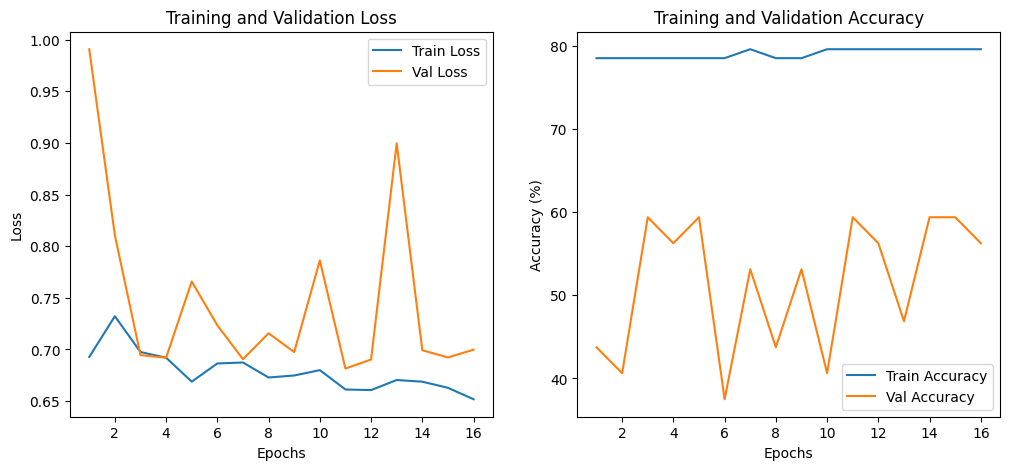

In [22]:
def plot_training(train_losses, val_losses, train_accuracies, val_accuracies):
    epochs = range(1, len(train_losses) + 1)

    plt.figure(figsize=(12, 5))
    
    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, train_losses, label='Train Loss')
    plt.plot(epochs, val_losses, label='Val Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training and Validation Loss')
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, train_accuracies, label='Train Accuracy')
    plt.plot(epochs, val_accuracies, label='Val Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy (%)')
    plt.title('Training and Validation Accuracy')
    plt.legend()

    plt.show()

plot_training(train_losses, val_losses, train_accuracies, val_accuracies)

### Confusion Matrix

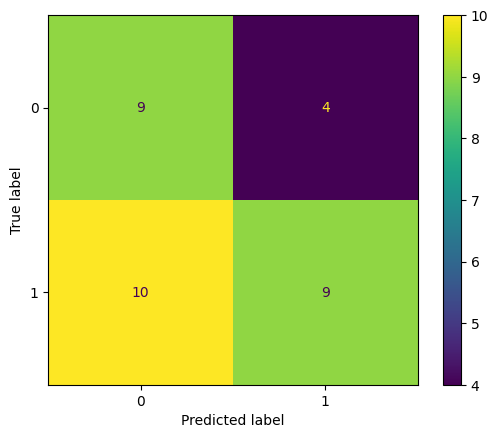

In [39]:
cm = conf_matrix.cpu().numpy()
disp = ConfusionMatrixDisplay(cm, display_labels=classes,)
disp.plot()

### AUC and ROC Curve

In [26]:
y_true = []
y_probs = []  # Collect probabilities for class 1 (cancer)

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:  # or test_loader
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)  # raw logits or softmax
        probs = torch.sigmoid(outputs)  # class 1 = cancer

        y_true.extend(labels.cpu().numpy())
        y_probs.extend(probs.cpu().numpy())

Slice read failed in /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0924_1-1.dcm: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: Unable to determine ImageIO reader for "/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0924_1-1.dcm"


AUC: 0.6275


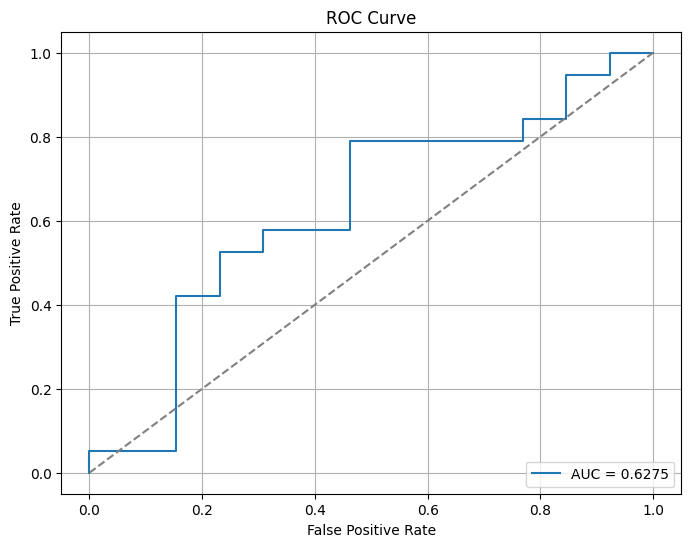

In [27]:
# Compute AUC
auc = roc_auc_score(y_true, y_probs)
print(f"AUC: {auc:.4f}")

# ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_probs)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, label=f"AUC = {auc:.4f}")
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

# Metrics

In [28]:
precision = MulticlassPrecision(num_classes=NUM_CLASSES, average=None)
recall = MulticlassRecall(num_classes=NUM_CLASSES, average=None)
f1_score = MulticlassF1Score(num_classes=NUM_CLASSES, average=None)


all_preds = []
all_labels = []

model.eval()
with torch.no_grad():
    for inputs, labels in val_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        all_preds.append(preds.cpu())
        all_labels.append(labels.cpu())


all_preds = torch.cat(all_preds)
all_labels = torch.cat(all_labels)


per_class_precision = precision(all_preds, all_labels)
per_class_recall = recall(all_preds, all_labels)
per_class_f1 = f1_score(all_preds, all_labels)


for i, name in enumerate(classes):
    print(f"Class {i}-{name}: Precision: {per_class_precision[i]:.2f}, Recall: {per_class_recall[i]:.2f}, F1-Score: {per_class_f1[i]:.2f}")

Slice read failed in /home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0924_1-1.dcm: Exception thrown in SimpleITK ImageFileReader_Execute: /tmp/SimpleITK/Code/IO/src/sitkImageReaderBase.cxx:99:
sitk::ERROR: Unable to determine ImageIO reader for "/home/vivianea/projects/BrainInnov/data/LIDC_classes_dcm/cancer/LIDC-IDRI-0924_1-1.dcm"
Class 0-0: Precision: 0.41, Recall: 1.00, F1-Score: 0.58
Class 1-1: Precision: 0.00, Recall: 0.00, F1-Score: 0.00


In [ ]:
# Save Model

In [ ]:
torch.save(model.state_dict(), PATH_MODEL)

# GradCam

In [29]:
def replace_relu_with_non_inplace(module):
    for name, child in module.named_children():
        if isinstance(child, torch.nn.ReLU) and child.inplace:
            setattr(module, name, torch.nn.ReLU(inplace=False))
        else:
            replace_relu_with_non_inplace(child)

replace_relu_with_non_inplace(model)

In [30]:
import scipy.ndimage

class GradCAM3D:
    def __init__(self, model, target_layer):
        self.model = model
        self.target_layer = target_layer
        self.gradients = None
        self.activations = None
        self._register_hooks()

    def _register_hooks(self):
        def forward_hook(module, input, output):
            self.activations = output.detach()

        def backward_hook(module, grad_in, grad_out):
            print("Backward hook triggered")
            self.gradients = grad_out[0].detach().clone()

        self.target_layer.register_forward_hook(forward_hook)
        self.target_layer.register_full_backward_hook(backward_hook)

    def generate(self, input_tensor, target_class=None):
        input_tensor = input_tensor.unsqueeze(0)  # Add batch dim if missing
        input_tensor = input_tensor.to(next(self.model.parameters()).device)
        input_tensor.requires_grad = True

        self.model.zero_grad()
        output = self.model(input_tensor)

        if target_class is None:
            target_class = torch.argmax(output)

        loss = output[0, target_class]
        loss.backward()

        if self.gradients is None:
            raise RuntimeError("Backward hook did not capture gradients.")

        weights = torch.mean(self.gradients, dim=[2, 3, 4], keepdim=True)
        cam = torch.sum(weights * self.activations, dim=1)
        cam = F.relu(cam)
        cam = cam.squeeze().cpu().detach().numpy()

        return cam, target_class

    def visualize(self, image_tensor, cam):
    

        image_np = image_tensor.squeeze().cpu().numpy()
        cam_np = cam  # Already a NumPy array

        # Resize CAM to match input shape
        cam_resized = scipy.ndimage.zoom(
            cam_np,
            zoom=(
                image_np.shape[0] / cam_np.shape[0],
                image_np.shape[1] / cam_np.shape[1],
                image_np.shape[2] / cam_np.shape[2],
            ),
            order=1,
        )

        center = image_np.shape[0] // 2
        fig, ax = plt.subplots(1, 2, figsize=(10, 5))
        ax[0].imshow(image_np[center], cmap='gray')
        ax[0].set_title("Original Slice")
        ax[1].imshow(image_np[center], cmap='gray')
        ax[1].imshow(cam_resized[center], cmap='jet', alpha=0.5)
        ax[1].set_title("Grad-CAM Overlay")
        plt.tight_layout()
        plt.show()

Backward hook triggered


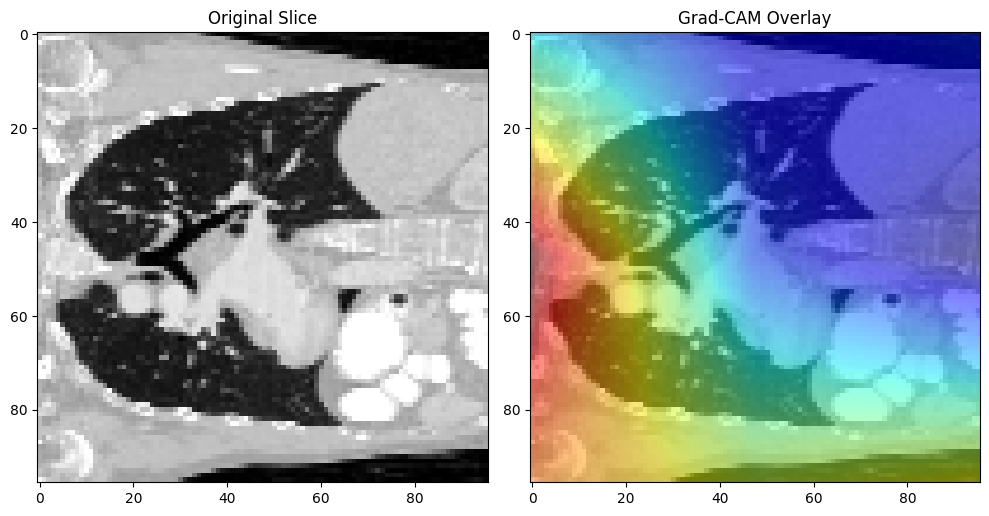

In [31]:
# Choose target layer (last conv in Densenet 3D)
target_layer = model.model.features.norm5

# Initialize GradCAM
grad_cam = GradCAM3D(model, target_layer)

# Run on one sample
image, label = test_dataset[0]  # image should be a tensor
cam, predicted_class = grad_cam.generate(image)

# Show visualization
grad_cam.visualize(image, cam)